In [129]:
### Music Artist Recommender Engine built with Apache Spark and Python

In [228]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pyspark.sql.functions import concat, col, lit
from pyspark.ml.recommendation import ALS
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import ParamGridBuilder, TrainValidationSplit, CrossValidator

In [229]:
from pyspark.sql import SparkSession, SQLContext
spark = SparkSession.builder \
    .master("yarn") \
    .appName("AspectDetector") \
    .enableHiveSupport() \
    .getOrCreate()

sqlContext = SQLContext(spark)

In [230]:
# Creating a pandas dataframe from Sample Data
df_pd = pd.read_csv("arating.csv")

# Creating a Spark DataFrame from a pandas dataframe
df_spark = sqlContext.createDataFrame(df_pd)

df_spark.show(5)

+-------+--------+------+
| userID|artistID|rating|
+-------+--------+------+
|1853593| 1022086|   100|
|1853593| 1022153|   100|
|1853593| 1022226|     0|
|1853593| 1022232|   100|
|1853593| 1023032|   100|
+-------+--------+------+
only showing top 5 rows



#### Load data
Load the two datasets of music artist information and user ratings.

In [231]:
artist = spark.read.load("canames.csv", format='csv', header = True)
music = spark.read.load("arating.csv", format='csv', header = True)

In [232]:
artist = artist.select("artistID", "artist")
artist.show(10)

+--------+--------------+
|artistID|        artist|
+--------+--------------+
|    -100|Not Applicable|
|     -99|Unknown Artist|
| 1000001| "Bobby ""O"""|
| 1000002| "Jimmy ""Z"""|
| 1000003|  '68 Comeback|
| 1000004|  'Til Tuesday|
| 1000005|The (EC) Nudes|
| 1000006|   .38 Special|
| 1000008|         1 + 1|
| 1000009|1 Of The Girls|
+--------+--------------+
only showing top 10 rows



In [233]:
music = music.select("userID", "artistID", "rating")
music.show(10)

+-------+--------+------+
| userID|artistID|rating|
+-------+--------+------+
|1853593| 1022086|   100|
|1853593| 1022153|   100|
|1853593| 1022226|     0|
|1853593| 1022232|   100|
|1853593| 1023032|   100|
|1853593| 1023157|   100|
|1853593| 1024006|     0|
|1853593| 1024051|   100|
|1853593| 1024379|    90|
|1853593| 1024602|   100|
+-------+--------+------+
only showing top 10 rows



#### Data processing

In [234]:
# Reset userID, artistID and rating dtypes
artist = artist.withColumn('artistID', artist['artistID'].cast('int'))
music = (music.withColumn('userID', music['userID'].cast('int'))
           .withColumn('artistID', music['artistID'].cast('int'))
           .withColumn('rating', music['rating'].cast('float')))

In [235]:
music.printSchema()

root
 |-- userID: integer (nullable = true)
 |-- artistID: integer (nullable = true)
 |-- rating: float (nullable = true)



In [236]:
artist.printSchema()

root
 |-- artistID: integer (nullable = true)
 |-- artist: string (nullable = true)



In [237]:
# Rating should be from 0-100, 255 implies do not play anymore
music = music.filter(music['rating'] <= 100)

In [238]:
music.describe().show()

+-------+------------------+------------------+-----------------+
|summary|            userID|          artistID|           rating|
+-------+------------------+------------------+-----------------+
|  count|            176288|            176288|           176288|
|   mean|1855143.9346467145|1034466.7762695135|51.46423466146306|
| stddev| 901.1489001399237| 32977.07674362838|40.38213227415712|
|    min|           1853593|             24538|              0.0|
|    max|           1856728|           1101719|            100.0|
+-------+------------------+------------------+-----------------+



#### Data Exploration
Check the number of artists and users.
Check the artist that with most ratings and users made most ratings.

In [239]:
top_artist = music.groupBy("artistID").count().orderBy('count', ascending=False)
top_user = music.groupBy("userID").count().orderBy('count', ascending=False)
top_artist.createOrReplaceTempView("top_artist")
top_user.createOrReplaceTempView("top_user")
artist.createOrReplaceTempView("artist")

In [240]:
top_artist.show()

+--------+-----+
|artistID|count|
+--------+-----+
| 1053507| 1250|
| 1098798| 1022|
| 1022226|  910|
| 1037847|  902|
| 1030879|  884|
| 1099097|  816|
| 1042768|  807|
| 1017240|  786|
| 1045704|  784|
| 1017874|  768|
| 1010787|  732|
| 1014312|  697|
| 1044487|  695|
| 1030760|  692|
| 1053653|  688|
| 1043454|  675|
| 1051565|  671|
| 1016600|  667|
| 1010542|  634|
| 1003522|  633|
+--------+-----+
only showing top 20 rows



In [241]:
artist.show()

+--------+-------------------+
|artistID|             artist|
+--------+-------------------+
|    -100|     Not Applicable|
|     -99|     Unknown Artist|
| 1000001|      "Bobby ""O"""|
| 1000002|      "Jimmy ""Z"""|
| 1000003|       '68 Comeback|
| 1000004|       'Til Tuesday|
| 1000005|     The (EC) Nudes|
| 1000006|        .38 Special|
| 1000008|              1 + 1|
| 1000009|     1 Of The Girls|
| 1000010|       1,000 Clowns|
| 1000011|        10 K.A.N.'s|
| 1000012|     10,000 Maniacs|
| 1000013|100 Degrees Celsius|
| 1000014|        100 Flowers|
| 1000015|          100 Proof|
| 1000016|      1000 Homo DJs|
| 1000017|    1000 Mona Lisas|
| 1000018|                101|
| 1000019|       101 Jade 4 U|
+--------+-------------------+
only showing top 20 rows



In [242]:
pop_artist = spark.sql("select artist,count \
                       from top_artist INNER JOIN artist \
                       on top_artist.artistID = artist.artistID \
                       order by top_artist.count desc")

In [243]:
pop_artist = pop_artist.selectExpr("artist as artist","count as no_rating")

In [244]:
# Show top 20 artist that have most ratings.
pop_artist.show(10)

+--------------------+---------+
|              artist|no_rating|
+--------------------+---------+
|         Linkin Park|     1250|
|         Evanescence|     1022|
|Red Hot Chili Pep...|      910|
|              Eminem|      902|
|       Missy Elliott|      884|
|              Chingy|      816|
|              Staind|      807|
|     Matchbox Twenty|      786|
|               Nelly|      784|
|           Metallica|      768|
+--------------------+---------+
only showing top 10 rows



In [245]:
top_pop_artist = pop_artist.select('artist').collect()

In [246]:
artist=[]

In [247]:
for i in range(5):
    artist.append(top_pop_artist[i].artist)

In [248]:
ratings = pop_artist.select('no_rating').collect()

In [249]:
No_of_ratings=[]

In [250]:
for i in range(5):
    No_of_ratings.append(ratings[i].no_rating)

(array([0, 1, 2, 3, 4]),
 [Text(0, 0, 'Linkin Park'),
  Text(1, 0, 'Evanescence'),
  Text(2, 0, 'Red Hot Chili Peppers'),
  Text(3, 0, 'Eminem'),
  Text(4, 0, 'Missy Elliott')])

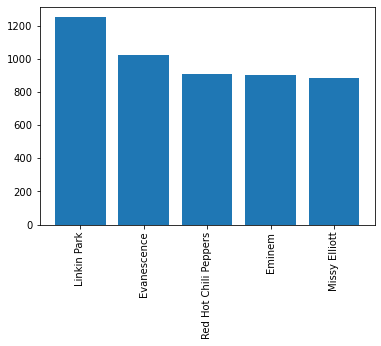

In [251]:
x = np.arange(5)
plt.bar(x, height=[No_of_ratings[0],No_of_ratings[1],No_of_ratings[2],No_of_ratings[3],No_of_ratings[4]])
plt.xticks(x, [artist[0],artist[1],artist[2],artist[3],artist[4]])
plt.xticks(rotation=90)

In [252]:
top_user = top_user.selectExpr("userId as userid", "count as no_rating")

In [253]:
top_user.show(10)

+-------+---------+
| userid|no_rating|
+-------+---------+
|1854922|     2844|
|1855309|     2127|
|1853843|     1888|
|1853729|     1866|
|1856495|     1337|
|1855876|     1198|
|1855470|     1065|
|1855600|     1035|
|1855758|      923|
|1855920|      910|
+-------+---------+
only showing top 10 rows



In [254]:
Most_Fre_userid = top_user.select('userID').collect()

In [255]:
user_id=[]

In [256]:
for i in range(5):
    user_id.append(Most_Fre_userid[i].userID)

In [257]:
Most_Fre_no_rating = top_user.select('no_rating').collect()

In [258]:
No_of_ratings=[]

In [259]:
for i in range(5):
    No_of_ratings.append(Most_Fre_no_rating[i].no_rating)

([<matplotlib.axis.XTick at 0x7f3f8dfd4610>,
 [Text(0, 0, '1854922'),
  Text(1, 0, '1855309'),
  Text(2, 0, '1853843'),
  Text(3, 0, '1853729'),
  Text(4, 0, '1856495')])

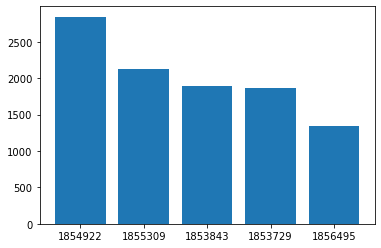

In [260]:
x = np.arange(5)
plt.bar(x, height=[No_of_ratings[0],No_of_ratings[1],No_of_ratings[2],No_of_ratings[3],No_of_ratings[4]])
plt.xticks(x, [user_id[0],user_id[1],user_id[2],user_id[3],user_id[4]])

In [261]:
temp1 = sum(music.groupBy("artistID").count().toPandas()['count'] == 1)
temp2 = music.select('artistID').distinct().count()
print ('{} out of {} artist with one rating'.format(temp1, temp2))
temp3 = sum(music.groupBy("userID").count().toPandas()['count'] == 1)
temp4 = music.select('userID').distinct().count()
print ('{} out of {} user rate one artist'.format(temp3, temp4))

2060 out of 8555 artist with one rating
320 out of 3135 user rate one artist


#### Split data into train and test.

In [73]:
# The datasets will be repeatedly used, persist them in memory using the cache function
train, test = music.randomSplit([0.8, 0.2], seed=1234)
train.cache()
test.cache()

DataFrame[userID: int, artistID: int, rating: float]

#### Build the recommender model using ALS

In [74]:
# If the rating matrix is derived from another source of information, you can set implicitPrefs to True to get better results.
als = ALS(userCol='userID', itemCol='artistID', ratingCol='rating', coldStartStrategy='drop')

In [75]:
# A CrossValidator requires an Estimator, a set of Estimator ParamMaps, and an Evaluator.
# We use a ParamGridBuilder to construct a grid of parameters to search over.
# this grid will have 2 x 5 x 4 = 40 parameter settings for CrossValidator to choose from.
paramGrid = ParamGridBuilder()\
    .addGrid(als.maxIter, [5, 10]) \
    .addGrid(als.regParam, [0.05, 0.1, 0.2, 0.4, 0.8])\
    .addGrid(als.rank, [6, 8, 10, 12])\
    .build()

In [76]:
crossval = CrossValidator(estimator=als,
                          estimatorParamMaps=paramGrid,
                          evaluator=RegressionEvaluator(metricName="rmse", labelCol="rating",
                          predictionCol="prediction"),
                          numFolds=2)

In [77]:
# Run cross-validation, and choose the best set of parameters.
cvModel = crossval.fit(train)

In [78]:
bestModel = cvModel.bestModel

In [79]:
# Make predictions on test data. model is the model with combination of parameters that performed best.
predictions = bestModel.transform(test)
predictions.show(5)

+-------+--------+------+-----------+
| userID|artistID|rating| prediction|
+-------+--------+------+-----------+
|1854678| 1001043|   0.0|-0.18345305|
|1855505| 1001043|  90.0|  7.9846654|
|1855920| 1001043|   0.0| -0.6338692|
|1855789| 1010495|   0.0|  1.9587995|
|1855794| 1010495|  90.0|   20.03146|
+-------+--------+------+-----------+
only showing top 5 rows



In [80]:
evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating",
                                predictionCol="prediction")
rmse_test = evaluator.evaluate(predictions)

In [81]:
# RMSE of the testing dataset
rmse_test

27.3257664434161

Compare the RMSE of ALS model with the benchmark results using mean rating of each artist as the prediction.

In [82]:
mean_df = train.groupby('artistId').mean().select('artistID','avg(rating)')
mean_df = mean_df.withColumnRenamed('avg(rating)','prediction')
mean_df.show(5)

+--------+------------------+
|artistID|        prediction|
+--------+------------------+
| 1030666|  65.8559670781893|
| 1098571| 31.21951219512195|
| 1053349|47.529411764705884|
| 1053407|  70.8671679197995|
| 1100657|50.564516129032256|
+--------+------------------+
only showing top 5 rows



In [83]:
test.createOrReplaceTempView("test")
mean_df.createOrReplaceTempView("mean_df")
mean_sql = spark.sql("select test.*, mean_df.prediction \
                       from test join mean_df \
                       on test.artistID = mean_df.artistID")

In [84]:
# RMSE of mean ratings
rmse_mean = evaluator.evaluate(mean_sql)
rmse_mean

37.057870106590855

ALS model has RMSE much less than using mean rating as prediction.

#### Make recommendations for a selected user

In [85]:
# Generate top 10 user recommendations for a specified set of movies
users = music.select(als.getUserCol()).distinct().limit(1)
userSubsetRecs = bestModel.recommendForUserSubset(users, 10)
users.show()

+-------+
| userID|
+-------+
|1853815|
+-------+



In [86]:
userSubsetRecs = userSubsetRecs.toPandas()
ans = []
for i in range(10):
  ans.append(userSubsetRecs[['recommendations']].iloc[0,0][i][0])
artist.where(col("artistID").isin(ans)).show()

+--------+--------------------+
|artistID|              artist|
+--------+--------------------+
| 1001178|       Archer & Park|
| 1002674|        Biggy Smallz|
| 1018845|         The Muppets|
| 1024086|        Shades Apart|
| 1028102|         Vanessa-Mae|
| 1031292|          Animaniacs|
| 1033789|         Sean Lennon|
| 1042975|Hedwig & The Angr...|
| 1069823|          Stillframe|
| 1100636|The Jessica Fletc...|
+--------+--------------------+

